<a href="https://colab.research.google.com/github/shu0518/hw2_m11423036/blob/main/%E5%AF%A6%E9%A9%97%E4%BA%8C/XGBoost_kfold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##1. 安裝及載入套件

In [ ]:
# 安裝套件
!pip install xgboost shap

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Scikit-learn 相關工具
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

# XGBoost
import xgboost as xgb

# SHAP
import shap

##2. 讀取資料集：Boston Housing dataset

In [ ]:
# Boston Housing 資料集的 14 個標準欄位名稱
column_names = [
    'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
    'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV'
]

# 載入資料
try:
    # --- 選項 1: 從 Colab 上傳的本機檔案讀取 (用於快速測試) ---
    # 如果您有將 'housing.csv' 直接上傳到 Colab，請取消註解並指定路徑
    local_file_path = None

    # --- 選項 2: 從 GitHub 原始 URL 讀取 (推薦用於作業提交) ---
    # 請將此 URL 替換為您的 housing.csv 檔案的原始 GitHub URL
    github_raw_url = 'https://raw.githubusercontent.com/shu0518/hw2_m11423036/refs/heads/main/housing.csv'

    if local_file_path:
        print(f"正在從本機檔案 '{local_file_path}' 載入資料...")
        # 使用原始字串 r'\s+' 避免 SyntaxWarning
        df = pd.read_csv(local_file_path, header=None, names=column_names, sep=r'\s+')
    else:
        print(f"正在從 GitHub URL '{github_raw_url}' 載入資料...")
        # 使用原始字串 r'\s+' 避免 SyntaxWarning
        df = pd.read_csv(github_raw_url, header=None, names=column_names, sep=r'\s+')

    print("資料集載入成功 (已手動指定欄位名稱)。")

    # 顯示前 5 筆資料
    print("\n資料集前 5 筆：")
    display(df.head())

    # 顯示資料基本資訊
    print("\n資料集資訊：")
    df.info()

except Exception as e:
    print(f"錯誤：載入資料時發生問題。請檢查您的檔案路徑、GitHub URL 或網路連線。錯誤訊息: {e}")

正在從 GitHub URL 'https://raw.githubusercontent.com/shu0518/hw2_m11423036/refs/heads/main/housing.csv' 載入資料...
資料集載入成功 (已手動指定欄位名稱)。

資料集前 5 筆：


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2



資料集資訊：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


##3. 資料前處理

In [ ]:
# 1. 檢查缺失值
print(f"資料集中總缺失值數量: {df.isnull().sum().sum()}")

# 2. 定義特徵 (X) 與目標 (y)
target_column = 'MEDV'
features = [col for col in df.columns if col != target_column]

X = df[features]
y = df[target_column]

print(f"特徵 (X) 欄位: {features}")
print(f"目標 (y) 欄位: {target_column}")

# 3. 特徵縮放
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 轉回 DataFrame，保留欄位名稱以便 SHAP 分析
X_scaled_df = pd.DataFrame(X_scaled, columns=features)

資料集中總缺失值數量: 0
特徵 (X) 欄位: ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
目標 (y) 欄位: MEDV


##4. XGBoost 搭配 K-Fold 交叉驗證

In [ ]:
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# 初始化 XGBoost 迴歸模型
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

fold_results = []
print(f"--- 開始 {k}-Fold 交叉驗證 ---")

for i, (train_index, test_index) in enumerate(kf.split(X_scaled_df)):

    # 取得訓練集與測試集
    X_train, X_test = X_scaled_df.iloc[train_index], X_scaled_df.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # 訓練模型
    model.fit(X_train, y_train)

    # 預測測試集
    y_pred = model.predict(X_test)

    # 計算績效指標
    mape = mean_absolute_percentage_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"Fold {i+1}: MAPE={mape:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}")
    fold_results.append({'MAPE': mape, 'RMSE': rmse, 'R2': r2})

# 計算 5-folds 平均績效
print("\n--- 5-Folds 平均績效 ---")
results_df_baseline = pd.DataFrame(fold_results)
baseline_metrics = results_df_baseline.mean()
print(baseline_metrics.to_string()) # 使用 .to_string() 避免輸出 dtype

--- 開始 5-Fold 交叉驗證 ---
Fold 1: MAPE=0.1054, RMSE=2.6285, R2=0.9058
Fold 2: MAPE=0.1047, RMSE=2.9846, R2=0.8866
Fold 3: MAPE=0.1191, RMSE=3.5243, R2=0.8635
Fold 4: MAPE=0.1102, RMSE=3.3436, R2=0.8930
Fold 5: MAPE=0.1008, RMSE=2.9433, R2=0.8795

--- 5-Folds 平均績效 ---
MAPE    0.108029
RMSE    3.084888
R2      0.885660


##4. SHAP 特徵重要性分析

SHAP 特徵重要性排名:


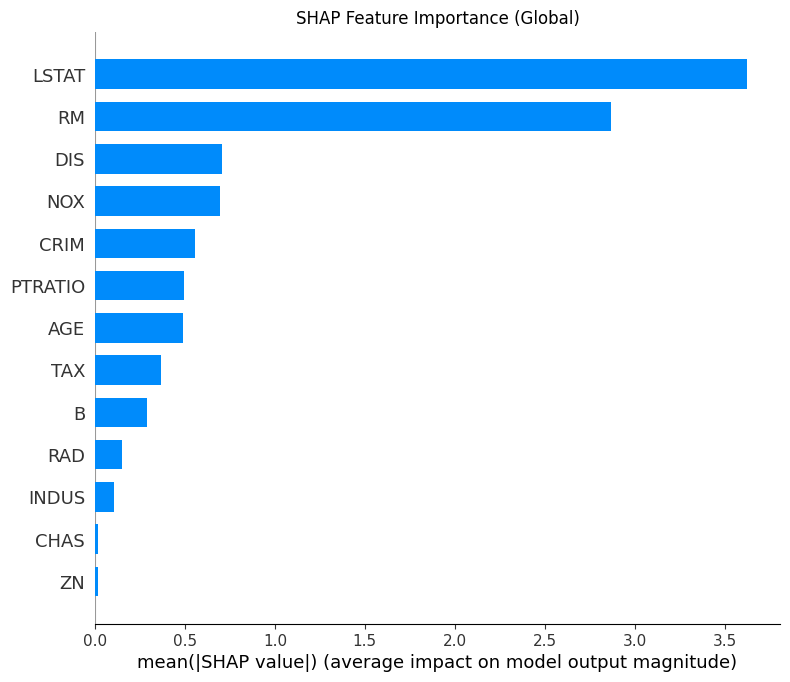

--- 特徵欄位重要性排序 ---


,feature,shap_importance,percentage
12,LSTAT,3.6260,34.92%
5,RM,2.8690,27.63%
7,DIS,0.7035,6.78%
4,NOX,0.6943,6.69%
0,CRIM,0.5559,5.35%
10,PTRATIO,0.4950,4.77%
6,AGE,0.4916,4.73%
9,TAX,0.3689,3.55%
11,B,0.2878,2.77%
8,RAD,0.1496,1.44%


In [ ]:
# 為了進行 SHAP 分析，我們在所有資料上訓練一個最終模型
final_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
final_model.fit(X_scaled_df, y)

# 初始化 SHAP Explainer
explainer = shap.Explainer(final_model)
shap_values = explainer(X_scaled_df)

print("SHAP 特徵重要性排名:")
# 繪製 Bar plot 顯示特徵重要性排名
shap.summary_plot(shap_values, X_scaled_df, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (Global)")
plt.show()

#繪製 Summary Plot (Dot Plot) 來觀察分佈
#print("\nSHAP 特徵分佈圖 (Summary Plot):")
#shap.summary_plot(shap_values, X_scaled_df)

# 計算全局 SHAP 重要性
shap_sum = np.abs(shap_values.values).mean(axis=0)
importance_df = pd.DataFrame({
    'feature': X_scaled_df.columns,
    'shap_importance': shap_sum
})

# 計算總重要性與 (數值) 百分比
total_importance = importance_df['shap_importance'].sum()
importance_df['percentage'] = (importance_df['shap_importance'] / total_importance) * 100

# 依重要性排序 (排序仍使用原始數值)
importance_df = importance_df.sort_values('shap_importance', ascending=False)

print("--- 特徵欄位重要性排序 ---")

display(importance_df.style.format({
    'shap_importance': '{:.4f}',  # 也順便將 SHAP 值格式化到小數點後 4 位
    'percentage': '{:.2f}%'     # 將 percentage 格式化為 "xx.xx%"
}))

# 原始的 importance_df 仍會被下一個 cell 使用

##5. 對特徵欄位篩選

設定三個篩選策略，必須要分開執行

1. Top-K： K=5 ，排名前五的特徵欄位

2. 設定閥值：移除 < 0.1% 的特徵

3. 累積重要性：從重要大到小累加重要性百分比直到 95.4%

###5.1 執行策略一

In [ ]:
# 檢查 importance_df 是否存在
if 'importance_df' not in locals():
    print("錯誤：請先執行上一個 Cell (步驟六) 來計算 importance_df")
else:

    # 策略 1: 選擇 Top-K (K=5)

    K = 5
    top_features_strat1 = importance_df.head(K)['feature'].tolist()
    print(f"--- 策略 1 (Top-{K}) 已啟用 ---")

    # 根據 'top_features_strat1' 列表建立篩選後的資料集
    features_to_remove = [f for f in features if f not in top_features_strat1]

    print(f"\n將被保留的特徵 ({len(top_features_strat1)} 個): {top_features_strat1}")
    print(f"將被移除的特徵 ({len(features_to_remove)} 個): {features_to_remove}")

    # 建立篩選後的資料集
    X_reduced_df_strat1 = X_scaled_df[top_features_strat1]

    print("\n篩選後的資料集 (前 5 筆):")
    display(X_reduced_df_strat1.head())

--- 策略 1 (Top-5) 已啟用 ---

將被保留的特徵 (5 個): ['LSTAT', 'RM', 'DIS', 'NOX', 'CRIM']
將被移除的特徵 (8 個): ['ZN', 'INDUS', 'CHAS', 'AGE', 'RAD', 'TAX', 'PTRATIO', 'B']

篩選後的資料集 (前 5 筆):


,LSTAT,RM,DIS,NOX,CRIM
0,-1.075562,0.413672,0.140214,-0.144217,-0.419782
1,-0.492439,0.194274,0.557160,-0.740262,-0.417339
2,-1.208727,1.282714,0.557160,-0.740262,-0.417342
3,-1.361517,1.016303,1.077737,-0.835284,-0.416750
4,-1.026501,1.228577,1.077737,-0.835284,-0.412482


###5.2 執行策略二

In [ ]:
if 'importance_df' not in locals():
    print("錯誤：請先執行上一個 Cell (步驟六) 來計算 importance_df")
else:

    # 策略 2: 閥值法 (移除 < 1% 的特徵)

    THRESHOLD = 1 # 單位: 百分比
    selected_df = importance_df[importance_df['percentage'] >= THRESHOLD]
    top_features_strat2 = selected_df['feature'].tolist()
    print(f"--- 策略 2 (閥值 >= {THRESHOLD}%) 已啟用 ---")

    # 根據 'top_features_strat2' 列表建立篩選後的資料集
    features_to_remove = [f for f in features if f not in top_features_strat2]

    print(f"\n將被保留的特徵 ({len(top_features_strat2)} 個): {top_features_strat2}")
    print(f"將被移除的特徵 ({len(features_to_remove)} 個): {features_to_remove}")

    # 建立篩選後的資料集
    X_reduced_df_strat2 = X_scaled_df[top_features_strat2]

    print("\n篩選後的資料集 (前 5 筆):")
    display(X_reduced_df_strat2.head())

--- 策略 2 (閥值 >= 1%) 已啟用 ---

將被保留的特徵 (11 個): ['LSTAT', 'RM', 'DIS', 'NOX', 'CRIM', 'PTRATIO', 'AGE', 'TAX', 'B', 'RAD', 'INDUS']
將被移除的特徵 (2 個): ['ZN', 'CHAS']

篩選後的資料集 (前 5 筆):


,LSTAT,RM,DIS,NOX,CRIM,PTRATIO,AGE,TAX,B,RAD,INDUS
0,-1.075562,0.413672,0.140214,-0.144217,-0.419782,-1.459000,-0.120013,-0.666608,0.441052,-0.982843,-1.287909
1,-0.492439,0.194274,0.557160,-0.740262,-0.417339,-0.303094,0.367166,-0.987329,0.441052,-0.867883,-0.593381
2,-1.208727,1.282714,0.557160,-0.740262,-0.417342,-0.303094,-0.265812,-0.987329,0.396427,-0.867883,-0.593381
3,-1.361517,1.016303,1.077737,-0.835284,-0.416750,0.113032,-0.809889,-1.106115,0.416163,-0.752922,-1.306878
4,-1.026501,1.228577,1.077737,-0.835284,-0.412482,0.113032,-0.511180,-1.106115,0.441052,-0.752922,-1.306878


###5.3 執行策略三

In [ ]:
if 'importance_df' not in locals():
    print("錯誤：請先執行上一個 Cell (步驟六) 來計算 importance_df")
else:
    # 策略 3: 累積重要性 (保留直到 95.4%)
    CUMULATIVE_THRESHOLD = 95.4 # 單位: 百分比

    # 1. 計算累積百分比
    importance_df['cumulative_percentage'] = importance_df['percentage'].cumsum()

    # 2. 找出 "小於等於" 閥值的所有特徵
    features_below_or_at_threshold = importance_df[importance_df['cumulative_percentage'] <= CUMULATIVE_THRESHOLD]

    # 3. 找出 "第一個大於" 閥值的特徵 (因為我們需要包含跨過 95.4% 的那一個)
    features_above_threshold = importance_df[importance_df['cumulative_percentage'] > CUMULATIVE_THRESHOLD]

    if not features_above_threshold.empty:
        first_feature_above = features_above_threshold.head(1)
        # 4. 合併
        selected_df = pd.concat([features_below_or_at_threshold, first_feature_above])
    else:
        # (如果總和剛好 100% 且未超過閥值，就全選)
        selected_df = importance_df

    top_features_strat3 = selected_df['feature'].tolist()
    print(f"--- 策略 3 (累積 <= {CUMULATIVE_THRESHOLD}%) 已啟用 ---")

    # 根據 'top_features_strat3' 列表建立篩選後的資料集
    features_to_remove = [f for f in features if f not in top_features_strat3]

    print(f"\n將被保留的特徵 ({len(top_features_strat3)} 個): {top_features_strat3}")
    print(f"將被移除的特徵 ({len(features_to_remove)} 個): {features_to_remove}")

    # 建立篩選後的資料集
    X_reduced_df_strat3 = X_scaled_df[top_features_strat3]

    print("\n篩選後的資料集 (前 5 筆):")
    display(X_reduced_df_strat3.head())

--- 策略 3 (累積 <= 95.4%) 已啟用 ---

將被保留的特徵 (9 個): ['LSTAT', 'RM', 'DIS', 'NOX', 'CRIM', 'PTRATIO', 'AGE', 'TAX', 'B']
將被移除的特徵 (4 個): ['ZN', 'INDUS', 'CHAS', 'RAD']

篩選後的資料集 (前 5 筆):


,LSTAT,RM,DIS,NOX,CRIM,PTRATIO,AGE,TAX,B
0,-1.075562,0.413672,0.140214,-0.144217,-0.419782,-1.459000,-0.120013,-0.666608,0.441052
1,-0.492439,0.194274,0.557160,-0.740262,-0.417339,-0.303094,0.367166,-0.987329,0.441052
2,-1.208727,1.282714,0.557160,-0.740262,-0.417342,-0.303094,-0.265812,-0.987329,0.396427
3,-1.361517,1.016303,1.077737,-0.835284,-0.416750,0.113032,-0.809889,-1.106115,0.416163
4,-1.026501,1.228577,1.077737,-0.835284,-0.412482,0.113032,-0.511180,-1.106115,0.441052


##6. 特徵篩選後績效指標

In [ ]:
import time

# --- 1. 定義可重複使用的 K-Fold 評估函式 ---
def evaluate_strategy(X_data, y_data, kf_object, strategy_name):
    """
    在給定的資料集上執行 5-Fold CV 並返回平均績效。

    Args:
        X_data (pd.DataFrame): 篩選後的特徵資料 (X_reduced_df_...)
        y_data (pd.Series): 目標變數 (y)
        kf_object (KFold): 已初始化的 KFold 物件 (kf)
        strategy_name (str): 用於 print 輸出的策略名稱

    Returns:
        pd.Series: 包含 MAPE, RMSE, R2 的平均績效
    """
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    fold_results = []

    print(f"--- 開始 5-Fold 交叉驗證 ( {strategy_name}) ---")

    for i, (train_index, test_index) in enumerate(kf_object.split(X_data)):
        # 取得訓練集與測試集
        X_train, X_test = X_data.iloc[train_index], X_data.iloc[test_index]
        y_train, y_test = y_data.iloc[train_index], y_data.iloc[test_index]

        # 訓練模型
        model.fit(X_train, y_train)

        # 預測測試集
        y_pred = model.predict(X_test)

        # 計算績效指標
        mape = mean_absolute_percentage_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        fold_results.append({'MAPE': mape, 'RMSE': rmse, 'R2': r2})

    # 計算 5-folds 平均績效
    avg_metrics = pd.DataFrame(fold_results).mean()

    print(f"--- 5-Folds 平均績效 ---")
    print(avg_metrics.to_string()) # 使用 .to_string() 避免輸出 dtype
    print("-" * 60) # 分隔線

    return avg_metrics

# --- 2. 執行所有策略的評估 ---
# 假設 'kf', 'y' 以及所有 X_reduced_df_stratX 都已在先前的 Cell 中定義

# 執行策略 1
strat1_metrics = evaluate_strategy(X_reduced_df_strat1, y, kf, f"策略 1: Top-{len(X_reduced_df_strat1.columns)} ")

# 執行策略 2
strat2_metrics = evaluate_strategy(X_reduced_df_strat2, y, kf, f"策略 2: 閥值法 ({len(X_reduced_df_strat2.columns)} ")

# 執行策略 3
strat3_metrics = evaluate_strategy(X_reduced_df_strat3, y, kf, f"策略 3: 累積重要性 (95.4%) ({len(X_reduced_df_strat3.columns)} ")

print("策略評估完成，結果已儲存至 strat1_metrics, strat2_metrics, strat3_metrics。")

--- 開始 5-Fold 交叉驗證 ( 策略 1: Top-5 ) ---
--- 5-Folds 平均績效 ---
MAPE    0.120143
RMSE    3.383380
R2      0.861479
------------------------------------------------------------
--- 開始 5-Fold 交叉驗證 ( 策略 2: 閥值法 (11 ) ---
--- 5-Folds 平均績效 ---
MAPE    0.108398
RMSE    3.000698
R2      0.891636
------------------------------------------------------------
--- 開始 5-Fold 交叉驗證 ( 策略 3: 累積重要性 (95.4%) (9 ) ---
--- 5-Folds 平均績效 ---
MAPE    0.107738
RMSE    2.971494
R2      0.893979
------------------------------------------------------------
策略評估完成，結果已儲存至 strat1_metrics, strat2_metrics, strat3_metrics。


##7. 最終績效比較

In [ ]:
comparison_df = pd.DataFrame({
    f"Baseline ({len(features)} Features)": baseline_metrics,
    f"Strategy 1 (Top-{K} Features)": strat1_metrics,
    f"Strategy 2 (閥值篩選 {THRESHOLD}%)": strat2_metrics,
    f"Strategy 3 (累積百分比 {CUMULATIVE_THRESHOLD}%)": strat3_metrics
})

print("--- 特徵篩選前後績效比較 (5-Fold 平均) ---")
display(comparison_df.T)

--- 特徵篩選前後績效比較 (5-Fold 平均) ---


,MAPE,RMSE,R2
Baseline (13 Features),0.108029,3.084888,0.885660
Strategy 1 (Top-5 Features),0.120143,3.383380,0.861479
Strategy 2 (閥值篩選 1%),0.108398,3.000698,0.891636
Strategy 3 (累積百分比 95.4%),0.107738,2.971494,0.893979
